In [2]:
from dataclasses import dataclass, field
from typing import Optional, Dict, Union, Literal

import torch
from gpytorch.constraints import Interval, GreaterThan, Positive
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel
from gpytorch.priors import GammaPrior, Prior
from torch.nn.functional import softplus


@dataclass
class Priors:
    lengthscale_prior: Prior = field(default_factory=lambda: GammaPrior(3.0, 0.5))
    outputscale_prior: Prior = field(default_factory=lambda: GammaPrior(3.0, 0.5))
    noise_prior: Prior = field(default_factory=lambda: GammaPrior(1.1, 0.05))
    df_prior: Prior = field(default_factory=lambda: GammaPrior(2.0, 0.15))

@dataclass
class Constraints:
    lengthscale_constraint: Interval = field(default_factory=Positive)
    outputscale_constraint: Interval = field(default_factory=Positive)
    noise_constraint: Interval = field(default_factory=Positive)
    df_constraint: Interval = field(default_factory=lambda: GreaterThan(2 + 1e-4))

@dataclass
class Device:
    device: torch.device = torch.device("cpu")
    dtype: torch.dtype = torch.float


@dataclass
class ModelConfig:
    ard_num_dims: Optional[int]  # Changed to Optional[int]
    kernel_type: Literal["rbf", "matern32", "matern52"] = "rbf"
    priors: Priors = field(default_factory=Priors)
    constraints: Constraints = field(default_factory=Constraints)
    device: Device = field(default_factory=Device)
    trained_params: Optional[Dict[str, Union[float, torch.Tensor]]] = None


def kronDelta(X, Xstar):
    return (X.unsqueeze(1) == Xstar.unsqueeze(0)).all(dim=2).float()


# ======================
# Kernel Creation Function
# ======================

def create_kernel(config: ModelConfig):
    """
    Creates the kernel for the GP or TP model based on the specified kernel type.
    """
    # Select base kernel based on kernel_type
    if config.kernel_type == "rbf":
        base_kernel = RBFKernel(
            ard_num_dims=config.ard_num_dims,
            lengthscale_prior=config.priors.lengthscale_prior
            if not (config.trained_params and "lengthscale" in config.trained_params)
            else None,
            lengthscale_constraint=config.constraints.lengthscale_constraint,
        )
    elif config.kernel_type == "matern32":
        base_kernel = MaternKernel(
            nu=1.5,
            ard_num_dims=config.ard_num_dims,
            lengthscale_prior=config.priors.lengthscale_prior
            if not (config.trained_params and "lengthscale" in config.trained_params)
            else None,
            lengthscale_constraint=config.constraints.lengthscale_constraint,
        )
    elif config.kernel_type == "matern52":
        base_kernel = MaternKernel(
            nu=2.5,
            ard_num_dims=config.ard_num_dims,
            lengthscale_prior=config.priors.lengthscale_prior
            if not (config.trained_params and "lengthscale" in config.trained_params)
            else None,
            lengthscale_constraint=config.constraints.lengthscale_constraint,
        )
    else:
        raise ValueError("Invalid kernel type specified. Choose from 'rbf', 'matern32', or 'matern52'.")

    # Set trained lengthscale if available
    if config.trained_params and "lengthscale" in config.trained_params:
        lengthscale_value = torch.tensor(config.trained_params["lengthscale"]).to(
            device=config.device.device, dtype=config.device.dtype
        )
        # Adjust shape based on ard_num_dims
        if config.ard_num_dims is not None:
            # ARD case: lengthscale is of shape (1, ard_num_dims, 1)
            lengthscale_value = lengthscale_value.view(1, config.ard_num_dims, 1)
        else:
            # Non-ARD case: lengthscale is scalar
            lengthscale_value = lengthscale_value
        base_kernel.initialize(lengthscale=lengthscale_value)

    # Wrap the base kernel with ScaleKernel
    kernel = ScaleKernel(
        base_kernel=base_kernel,
        outputscale_prior=config.priors.outputscale_prior
        if not (config.trained_params and "outputscale" in config.trained_params)
        else None,
        outputscale_constraint=config.constraints.outputscale_constraint,
    )

    # Set trained outputscale if available
    if config.trained_params and "outputscale" in config.trained_params:
        outputscale_value = torch.tensor(config.trained_params["outputscale"]).to(
            device=config.device.device, dtype=config.device.dtype
        )
        kernel.initialize(outputscale=outputscale_value)

    return kernel


# ======================
# CovFunc Class with Noise Handling using kronDelta
# ======================

class CovarianceFunction:
    def __init__(self, config: ModelConfig):
        """
        Covariance function wrapper with noise handling for Gaussian Process kernels.
        
        Parameters
        ----------
        config : ModelConfig
            Configuration object that includes kernel type, priors, constraints, and noise settings.
        """
        self.config = config
        self.kernel = create_kernel(config)
        
        # Set noise level as a trainable parameter
        if config.trained_params and "noise" in config.trained_params:
            self.raw_noise = torch.nn.Parameter(
                torch.tensor(config.trained_params["noise"], device=config.device.device, dtype=config.device.dtype)
            )
        else:
            # Initialize with the mean of the noise prior if not specified in trained_params
            self.raw_noise = torch.nn.Parameter(
                torch.tensor(config.priors.noise_prior.mean, device=config.device.device, dtype=config.device.dtype)
            )

    @property
    def noise(self):
        """Apply softplus to ensure noise is positive."""
        return softplus(self.raw_noise)
    
    def get_params(self) -> Dict[str, torch.Tensor]:
        """
        Returns a dictionary of trainable parameters for optimization.

        Returns
        -------
        list
            List of trainable parameters (raw lengthscale, outputscale, noise).
        """
        return {
            "lengthscale": self.kernel.base_kernel.raw_lengthscale,
            "outputscale": self.kernel.raw_outputscale,
            "noise": self.raw_noise
        }

    def K(self, X, Xstar):
        """
        Computes the covariance matrix including noise using kronDelta.

        Parameters
        ----------
        X : torch.Tensor, shape=(n_samples, n_features)
            Input data.
        Xstar : torch.Tensor, shape=(m_samples, n_features)
            Input data for prediction.

        Returns
        -------
        torch.Tensor
            Covariance matrix with noise component.
        """

        # Kernel matrix computation
        K = self.kernel(X, Xstar).evaluate()
        
        # Add observation noise
        K += self.noise * kronDelta(X, Xstar)
        
        return K

# ======================
# Sample Usage
# ======================

# Config with Specific Kernel Type and Initial Values for Lengthscale, Outputscale, and Noise
config = ModelConfig(
    ard_num_dims=None,  # Set to None for non-ARD (scalar lengthscale)
    kernel_type="matern32",  # "rbf", "matern32", or "matern52"
    trained_params={"lengthscale": 1.0, "outputscale": 1.0, "noise": 0.1}
)

cov_func = CovarianceFunction(config)

# Example data
X = torch.tensor([[1.0], [2.0], [3.0]])
K = cov_func.K(X, X)  # X and Xstar are the same, so noise is added

# ======================
# Print Results
# ======================

print("Covariance matrix with noise:\n", K)
print(f"kernel: \n{cov_func.kernel}\n")
print(f"lengthscale: {cov_func.kernel.base_kernel.lengthscale.item()}")
print(f"outputscale: {cov_func.kernel.outputscale.item()}")


Covariance matrix with noise:
 tensor([[1.7444, 0.4834, 0.1397],
        [0.4834, 1.7444, 0.4834],
        [0.1397, 0.4834, 1.7444]], grad_fn=<AddBackward0>)
kernel: 
ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

lengthscale: 1.0
outputscale: 1.0


In [6]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS


class GaussianProcessMCMC:
    def __init__(self, covfunc, niter=2000, num_chains=1, warmup_steps=1000, mprior=0.0):
        """
        Gaussian Process class using MCMC sampling of covariance function hyperparameters.

        Parameters
        ----------
        covfunc: instance of covariance function class
            Covariance function to use. Currently supports `squaredExponential`, `matern32`, and `matern52`.
        niter: int
            Number of MCMC samples to draw.
        num_chains: int
            Number of MCMC chains to run in parallel.
        warmup_steps: int
            Number of warm-up (burn-in) steps before sampling.
        mprior: float
            Prior mean of the Gaussian Process.
        """
        self.covfunc = covfunc
        self.niter = niter
        self.num_chains = num_chains
        self.warmup_steps = warmup_steps
        self.mprior = mprior

    def model(self, X, y):
        """
        Probabilistic model for the Gaussian Process with hyperparameter priors.
        """
        # Define priors for hyperparameters
        lengthscale = pyro.sample('lengthscale', dist.Uniform(0.1, 10.0).expand([1]).to_event(1))
        outputscale = pyro.sample('outputscale', dist.LogNormal(0.0, 1.0))
        noise = pyro.sample('noise', dist.LogNormal(0.0, 1.0))

        # Update covariance function hyperparameters
        self.covfunc.kernel.base_kernel.lengthscale = lengthscale
        self.covfunc.kernel.outputscale = outputscale
        noise_matrix = noise * torch.eye(X.shape[0], device=X.device)

        # Compute covariance matrix
        K = self.covfunc.K(X, X) + noise_matrix

        # Sample from multivariate normal
        pyro.sample('y_obs', dist.MultivariateNormal(torch.zeros(X.shape[0], device=X.device), covariance_matrix=K), obs=y)

    def fit(self, X, y):
        """
        Fits the Gaussian Process regressor using MCMC sampling of hyperparameters.

        Parameters
        ----------
        X: torch.Tensor, shape=(n_samples, n_features)
            Training instances.
        y: torch.Tensor, shape=(n_samples,)
            Target values.
        """
        self.X = X
        self.y = y

        # Use NUTS sampler
        nuts_kernel = NUTS(self.model)
        mcmc = MCMC(nuts_kernel, num_samples=self.niter, warmup_steps=self.warmup_steps, num_chains=self.num_chains)
        mcmc.run(X, y)
        self.trace = mcmc.get_samples()

    def predict(self, Xstar, return_std=False, nsamples=10):
        """
        Predicts using the posterior samples of the Gaussian Process.

        Parameters
        ----------
        Xstar: torch.Tensor, shape=(n_test_samples, n_features)
            Test instances.
        return_std: bool
            If True, returns the standard deviation of the predictions.
        nsamples: int
            Number of posterior samples to use for prediction.

        Returns
        -------
        torch.Tensor
            Predictive means.
        torch.Tensor
            Predictive variances or standard deviations.
        """
        # Draw posterior samples of hyperparameters
        samples = {key: self.trace[key][-nsamples:] for key in ['lengthscale', 'outputscale', 'noise']}
        post_mean, post_var = [], []

        for i in range(nsamples):
            # Set sampled hyperparameters
            self.covfunc.kernel.base_kernel.lengthscale = samples['lengthscale'][i]
            self.covfunc.kernel.outputscale = samples['outputscale'][i]
            noise = samples['noise'][i]

            # Compute predictive mean and covariance
            K_train = self.covfunc.K(self.X, self.X) + noise * torch.eye(self.X.size(0), device=self.X.device)
            K_train_test = self.covfunc.K(self.X, Xstar)
            K_test = self.covfunc.K(Xstar, Xstar)

            L = torch.linalg.cholesky(K_train)
            alpha = torch.cholesky_solve((self.y - self.mprior).unsqueeze(1), L).squeeze()

            fmean = torch.matmul(K_train_test.t(), alpha) + self.mprior
            v = torch.cholesky_solve(K_train_test, L)
            fcov = K_test - torch.matmul(K_train_test.t(), v)

            post_mean.append(fmean)
            post_var.append(fcov if not return_std else torch.sqrt(torch.diag(fcov)))

        mean = torch.stack(post_mean).mean(dim=0)
        if return_std:
            std = torch.stack(post_var).mean(dim=0)
            return mean, std
        else:
            cov = torch.stack(post_var).mean(dim=0)
            return mean, cov

    def update(self, xnew, ynew):
        """
        Updates the model with new observations.

        Parameters
        ----------
        xnew: torch.Tensor, shape=(n_new_samples, n_features)
            New training instances.
        ynew: torch.Tensor, shape=(n_new_samples,)
            New target values.
        """
        self.X = torch.cat((self.X, xnew), dim=0)
        self.y = torch.cat((self.y, ynew), dim=0)
        self.fit(self.X, self.y)

/var/folders/_b/b62kq0490fn2ptq7m4mbp8yr0000gp/T/ipykernel_4477/2409231441.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(config.priors.noise_prior.mean, device=config.device.device, dtype=config.device.dtype)
Sample: 100%|██████████| 1500/1500 [00:12, 123.06it/s, step size=6.73e-01, acc. prob=0.829]


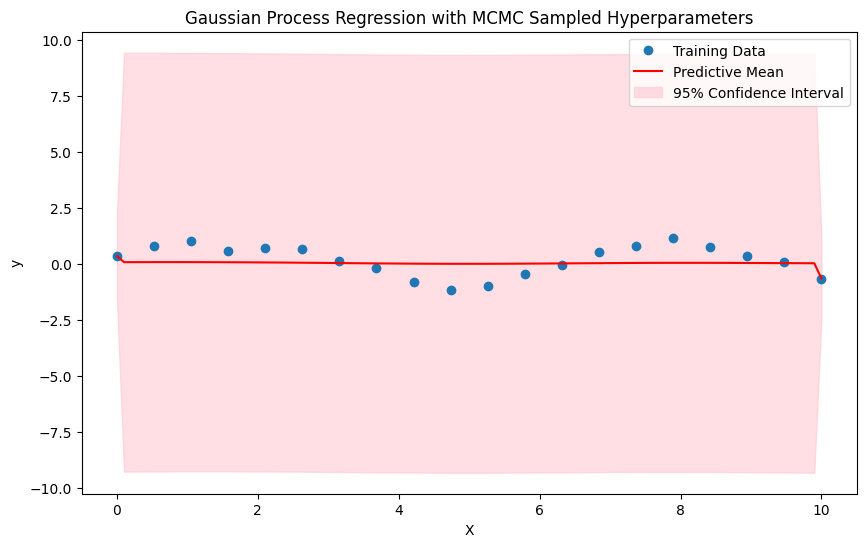

Sampled lengthscale: 6.853966236114502
Sampled outputscale: 0.5282976627349854
Sampled noise: 0.31868207454681396


In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data
torch.manual_seed(42)
X_train = torch.linspace(0, 10, 20).unsqueeze(1)  # Shape (20, 1)
y_train = torch.sin(X_train).squeeze() + 0.2 * torch.randn(X_train.size(0))  # Shape (20,)

# Define ModelConfig with initial parameters
config = ModelConfig(
    ard_num_dims=1,          # 1D input, no ARD
    kernel_type="matern32",   # Using Matern 3/2 kernel
    trained_params=None       # No initial trained parameters for MCMC
)

# Initialize CovFunc with config
cov_func = CovarianceFunction(config)

# Initialize GaussianProcessMCMC with cov_func
gp_mcmc = GaussianProcessMCMC(cov_func, niter=1000, num_chains=1, warmup_steps=500)

# Fit the model to training data using MCMC sampling
gp_mcmc.fit(X_train, y_train)

# Generate test data for prediction
X_test = torch.linspace(0, 10, 100).unsqueeze(1)

# Make predictions with the trained GP model using posterior samples
fmean, fcov = gp_mcmc.predict(X_test, return_std=True, nsamples=50)

# Plot the results
fmean = fmean.detach().numpy()
std_dev = fcov.detach().numpy() if isinstance(fcov, torch.Tensor) else np.sqrt(np.diag(fcov))

# Plot training data, predictive mean, and confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(X_train.numpy(), y_train.numpy(), 'o', label='Training Data')
plt.plot(X_test.numpy(), fmean, 'r', label='Predictive Mean')
plt.fill_between(X_test.numpy().flatten(),
                 fmean - 1.96 * std_dev,
                 fmean + 1.96 * std_dev,
                 color='pink', alpha=0.5, label='95% Confidence Interval')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Gaussian Process Regression with MCMC Sampled Hyperparameters")
plt.show()

# Print sampled parameters (example for the last sample)
print("Sampled lengthscale:", gp_mcmc.trace['lengthscale'][-1].item())
print("Sampled outputscale:", gp_mcmc.trace['outputscale'][-1].item())
print("Sampled noise:", gp_mcmc.trace['noise'][-1].item())
